**U-Net 13 bands**

Dataset

In [1]:
import sys
sys.path.append("..")
sys.path.append("..")

from src import dataset, metadata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
import time

from torchsummary import summary

import optuna

In [2]:
df_s2 = metadata.process_metadata("/media/disk/databases/cloudsen12/high/hq_data.csv")

df_s2 = df_s2.reset_index()
df_s2

,index,user,ROI,sen2,cloud_per,cloud_coverage,sensing_time,year,path
0,0,ANDREA,point_0317,20190207T172509_20190207T173213_T13QGG,0.0,cloud-free,2019-02-07 17:25:09+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
1,5,ANDREA,point_0320,20190409T164849_20190409T165500_T16UGD,0.0,cloud-free,2019-04-09 16:48:49+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
2,10,ANDREA,point_0323,20200407T222531_20200407T222530_T04WDS,0.0,cloud-free,2020-04-07 22:25:31+00:00,2020,/media/disk/databases/cloudsen12/high/point_03...
3,15,ANDREA,point_0329,20190114T101351_20190114T102032_T31PDP,0.0,cloud-free,2019-01-14 10:13:51+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
4,20,ANDREA,point_0332,20190127T070141_20190127T071456_T39NTJ,0.0,cloud-free,2019-01-27 07:01:41+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
...,...,...,...,...,...,...,...,...,...
1995,9975,WENDY,point_9969,20190327T054641_20190327T055021_T43RCQ,0.0,cloud-free,2019-03-27 05:46:41+00:00,2019,/media/disk/databases/cloudsen12/high/point_99...
1996,9980,WENDY,point_9976,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...
1997,9985,WENDY,point_9980,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...
1998,9990,WENDY,point_9981,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...


In [3]:
df_pv = metadata.process_metadata("/media/disk/databases/cloudsen12/highprobav/processed_probav.csv")
df_pv

,ROI,user,sen2,cloud_per,cloud_coverage,sensing_time,year,path,bounds_latlong,bounds,crs_chips,geometry,center_latlong,PV100TOC,PV100TOA,PV_diff_days,PV_frac_invalids,PV_frac_clouds,missing
0,point_0317,ANDREA,20190207T172509_20190207T173213_T13QGG,0.0,cloud-free,2019-02-07 17:25:09+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(-102.33019815388593, 24.313454163761712, -102...","BoundingBox(left=770950.0, bottom=2691630.0, r...",EPSG:32613,POLYGON ((-102.33019815388593 24.3134541637617...,"(-102.30465226392862, 24.336860226798464)",PROBAV_S1_TOC_X07Y05_20190209_100M_V101.HDF5,PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5,2.0,0.000000,0.157719,False
1,point_0320,ANDREA,20190409T164849_20190409T165500_T16UGD,0.0,cloud-free,2019-04-09 16:48:49+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(-83.8758104013502, 52.4839623391974, -83.7976...","BoundingBox(left=712120.0, bottom=5819680.0, r...",EPSG:32616,"POLYGON ((-83.8758104013502 52.4839623391974, ...","(-83.83672824372164, 52.50780920150713)",PROBAV_S1_TOC_X09Y02_20190410_100M_V101.HDF5,PROBAV_S1_TOA_X09Y02_20190410_100M_V101.HDF5,1.0,0.000000,0.929783,False
2,point_0323,ANDREA,20200407T222531_20200407T222530_T04WDS,0.0,cloud-free,2020-04-07 22:25:31+00:00,2020,/media/disk/databases/cloudsen12/highprobav/po...,"(-159.79539236149657, 64.77396032968922, -159....","BoundingBox(left=462240.0, bottom=7183500.0, r...",EPSG:32604,POLYGON ((-159.79539236149657 64.7739603296892...,"(-159.74120686918297, 64.79706207184097)",PROBAV_S1_TOC_X02Y01_20200406_100M_V101.HDF5,PROBAV_S1_TOA_X02Y01_20200406_100M_V101.HDF5,-1.0,0.099609,0.900391,False
3,point_0329,ANDREA,20190114T101351_20190114T102032_T31PDP,0.0,cloud-free,2019-01-14 10:13:51+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(2.261778764637082, 12.234735220472697, 2.3087...","BoundingBox(left=419720.0, bottom=1352620.0, r...",EPSG:32631,POLYGON ((2.261778764637082 12.234735220472697...,"(2.285240232661488, 12.257809363657463)",PROBAV_S1_TOC_X18Y06_20190114_100M_V101.HDF5,PROBAV_S1_TOA_X18Y06_20190114_100M_V101.HDF5,0.0,0.000000,0.000000,False
4,point_0332,ANDREA,20190127T070141_20190127T071456_T39NTJ,0.0,cloud-free,2019-01-27 07:01:41+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(48.77810415711981, 7.734263085540499, 48.8244...","BoundingBox(left=254960.0, bottom=855560.0, ri...",EPSG:32639,"POLYGON ((48.77810415711981 7.734263085540499,...","(48.801287685585876, 7.757386441728896)",PROBAV_S1_TOC_X22Y06_20190127_100M_V101.HDF5,PROBAV_S1_TOA_X22Y06_20190127_100M_V101.HDF5,0.0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,point_9969,WENDY,20190327T054641_20190327T055021_T43RCQ,0.0,cloud-free,2019-03-27 05:46:41+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(73.1428297673523, 30.83039542287769, 73.19691...","BoundingBox(left=322460.0, bottom=3412280.0, r...",EPSG:32643,"POLYGON ((73.1428297673523 30.83039542287769, ...","(73.16987025227952, 30.85372441757002)",PROBAV_S1_TOC_X25Y04_20190326_100M_V101.HDF5,PROBAV_S1_TOA_X25Y04_20190326_100M_V101.HDF5,-1.0,0.000000,0.352837,False
1996,point_9976,WENDY,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/highprobav/po...,"(74.17119907381326, 32.172166988823975, 74.225...","BoundingBox(left=421900.0, bottom=3559820.0, r...",EPSG:32643,POLYGON ((74.17119907381326 32.172166988823975...,"(74.19839903147333, 32.195295680860795)",PROBAV_S1_TOC_X25Y04_20181217_100M_V101.HDF5,PROBAV_S1_TOA_X25Y04_20181217_100M_V101.HDF5,0.0,1.000000,0.000000,False
1997,point_9980,WENDY,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/highprobav/po...,"(72.05048765833794, 31.77290206935128, 72.1057...","BoundingBox(left=788900.0, bottom=3519460.0, r...",EPSG:32642,"POLYGON ((72.05048765833794 31.77290206935128,...","(72.07809412765002, 31.79647972

In [4]:
df_s2['cloud_coverage'].unique()

array(['cloud-free'], dtype=object)

In [5]:
df_pv['cloud_coverage'].unique()

array(['cloud-free'], dtype=object)

In [6]:
df_pv.isnull().sum()

ROI                   0
user                  0
sen2                  0
cloud_per             0
cloud_coverage        0
sensing_time          0
year                  0
path                  0
bounds_latlong        0
bounds                0
crs_chips             0
geometry              0
center_latlong        0
PV100TOC            100
PV100TOA            100
PV_diff_days        100
PV_frac_invalids    119
PV_frac_clouds      119
missing               0
dtype: int64

In [7]:
np.sum(df_pv['PV100TOC'].isnull() != df_pv['PV100TOA'].isnull())

0

In [8]:
df_pv['PV_frac_clouds'].unique()

array([1.57718658e-01, 9.29782867e-01, 9.00390625e-01, ...,
       4.88601685e-01, 3.52836609e-01, 7.82012939e-04])

In [9]:
#train-test split

points = ['point_0502', 'point_0523', 'point_0537', 'point_0588', 'point_0645', 'point_0842',
               'point_0845', 'point_0882', 'point_0916', 'point_0917', 'point_0944', 'point_0983',
               'point_0992', 'point_10634', 'point_11224', 'point_11337', 'point_11588', 'point_0110',
               'point_0155', 'point_0188', 'point_0278', 'point_0322', 'point_0434', 'point_0521', 'point_0542',
               'point_0792', 'point_1302', 'point_1357', 'point_1385', 'point_1398', 'point_1771', 'point_0036',
               'point_0165', 'point_0267', 'point_0357', 'point_0399', 'point_0474', 'point_0483', 'point_0498',
               'point_0557', 'point_0562', 'point_0563', 'point_1019', 'point_1028', 'point_1043', 'point_1061',
               'point_1068', 'point_1084', 'point_1099', 'point_1124', 'point_11274', 'point_0028', 'point_0037',
               'point_0142', 'point_0214', 'point_0286', 'point_0313', 'point_0373', 'point_0487', 'point_1208',
               'point_1238', 'point_1244', 'point_1273', 'point_1276', 'point_1277', 'point_1290', 'point_1296',
               'point_11862', 'point_11920', 'point_12023', 'point_2972', 'point_3153', 'point_8099', 'point_2088',
               'point_2421', 'point_2446', 'point_2755', 'point_3400', 'point_6317', 'point_6464', 'point_6543',
               'point_6869', 'point_7355', 'point_7445', 'point_8402', 'point_9054', 'point_0800', 'point_0812',
               'point_0820', 'point_0822', 'point_0823', 'point_4211', 'point_4325', 'point_3848', 'point_3897',
               'point_4140', 'point_4495', 'point_5786', 'point_0290', 'point_3316']

test_samples = [item in points for item in df_s2['ROI']]

df_test = df_s2[test_samples]
df_train = df_s2.loc[~df_s2.index.isin(df_test.index)]

In [10]:
print(f"Total: {df_pv.shape[0]} missing {np.sum(df_pv['missing'])}")

Total: 2000 missing 119


In [11]:
len(df_train), len(df_test)

(1900, 100)

In [12]:
any(item in df_test.index for item in df_train.index)

False

In [13]:
ds_train = dataset.TiffDataset(df_train, 256, False)
len(ds_train)

1900

313


Text(0.5, 1.0, 'L2A')

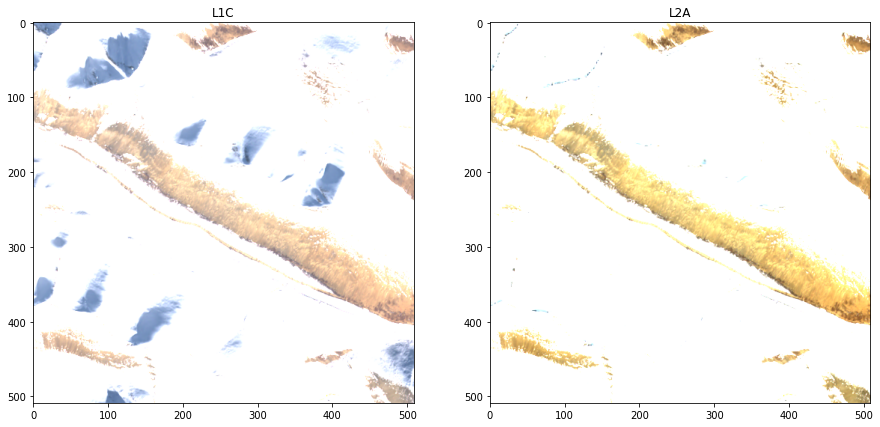

In [14]:
idx = np.random.randint(0,len(ds_train))
print(idx)
item = ds_train[idx]
item["sl1c"].shape,item["sl2a"].shape

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)
#rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) * 1.0 / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)
#rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) * 1.0 /  0.3, 0,1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")
ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")

In [16]:
fig.savefig("input.png", bbox_inches='tight')

Models

U-NET

In [15]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, n_channels, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [16]:
model = UNet(13, 13)
summary(model, (13, 504, 504))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 504, 504]           7,552
              ReLU-2         [-1, 64, 504, 504]               0
            Conv2d-3         [-1, 64, 504, 504]          36,928
              ReLU-4         [-1, 64, 504, 504]               0
         MaxPool2d-5         [-1, 64, 252, 252]               0
            Conv2d-6        [-1, 128, 252, 252]          73,856
              ReLU-7        [-1, 128, 252, 252]               0
            Conv2d-8        [-1, 128, 252, 252]         147,584
              ReLU-9        [-1, 128, 252, 252]               0
        MaxPool2d-10        [-1, 128, 126, 126]               0
           Conv2d-11        [-1, 256, 126, 126]         295,168
             ReLU-12        [-1, 256, 126, 126]               0
           Conv2d-13        [-1, 256, 126, 126]         590,080
             ReLU-14        [-1, 256, 1

In [17]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = UNet(13, 14)
preds = model(x)
print(preds.shape)

torch.Size([1, 14, 256, 256])


FCNN

In [18]:
class FCNN(nn.Module):

    def __init__(self):
        super(FCNN, self).__init__()
        # Learnable layers
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=14, kernel_size=5, padding=2)


    def forward(self, x):
        # x.size() = (N, 13, W, W) 
        x = F.relu(self.conv1(x)) 
        # x.size() = (N, 32, W, W) 
        x = F.relu(self.conv2(x))
        # x.size() = (N, 64, W, W)  
        x = F.relu(self.conv3(x))
        # x.size() = (N, 32, W, W)
        x = self.conv4(x)
        # x.size() = (N, 14, W, W)
        return x

In [19]:
model = FCNN()
summary(model, (13, 509, 509))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 509, 509]           3,776
            Conv2d-2         [-1, 64, 509, 509]          18,496
            Conv2d-3         [-1, 32, 509, 509]          18,464
            Conv2d-4         [-1, 14, 509, 509]          11,214
Total params: 51,950
Trainable params: 51,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.85
Forward/backward pass size (MB): 280.68
Params size (MB): 0.20
Estimated Total Size (MB): 293.73
----------------------------------------------------------------


In [20]:
#Check everything is correct

x = torch.randn((1, 13, 256, 256))
model = FCNN()
preds = model(x)
print(preds.shape)

torch.Size([1, 14, 256, 256])


Train

In [25]:
# initialize our model
model = UNet(13,14)

#If we want to load some model weights:

#model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

# initialize loss function and optimizer
lossFunc = MSELoss()
opt = Adam(model.parameters(), lr= 0.001) #best_trial.params['lr'])#torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['lr'])

# calculate steps per epoch for training and test set
#trainSteps = 600 # len(train_input)
#valSteps = 300 # len(val_input)

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

# select number of epochs
num_epochs = 10


In [26]:
batch_size = 12

'''trainDS = []
valDS = []

for idx in range(len(train_input)):
    trainDS.append((train_input[idx],train_target[idx]))

for idx in range(len(val_input)):
    valDS.append((val_input[idx], val_target[idx]))'''

df_training = df_train.sample(frac=0.7)
df_val = df_train.loc[~df_train.index.isin(df_training.index)]

window = 504

trainDS = dataset.TiffDataset(df_training, window, True)
valDS = dataset.TiffDataset(df_val, window, True)

#trainDS = dataset.TiffDataset(df_training, window, True)
#valDS = dataset.TiffDataset(df_val, window, True)
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

# calculate steps per epoch for training and test set
trainSteps = len(trainLoader) # len(train_input)
valSteps = len(valLoader) # len(val_input)

In [ ]:
# loop over epochs
train_metrics = []
val_metrics = []
alpha = 0#0.5527348400239881 #best_trial.params['alpha']#torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['alpha']#best_trial.params['alpha']
beta = 0.2#0.47372661647181813 #best_trial.params['beta'] #torch.load('saved_models/fcnn_e15_batch10_model_save.pth')['params']['beta']#best_trial.params['beta']



print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for sample in trainLoader:
		# send the input to the device
		#x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
		#y = y.reshape(1, y.shape[0], y.shape[1], y.shape[2])
		x = sample['sl1c']
		y = sample['sl2a']

		# perform a forward pass and calculate the training loss
		pred = model(x)
		train_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
		train_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
		train_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])
		loss = train_rad_loss + alpha*train_aot_loss + beta*train_wvp_loss

		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for sample in valLoader:
			# send the input to the device
			#x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
			#y = y.reshape(1, y.shape[0], y.shape[1], y.shape[2])
			x = sample['sl1c']
			y = sample['sl2a']

			# make the predictions and calculate the validation loss
			pred = model(x)
			val_rad_loss = lossFunc(pred[:, :12, :, :], y[:, :12, :, :])
			val_aot_loss = lossFunc(pred[:, 12, :, :], y[:, 12, :, :])
			val_wvp_loss = lossFunc(pred[:, 13, :, :], y[:, 13, :, :])
			totalValLoss += val_rad_loss + alpha*val_aot_loss + beta*val_wvp_loss

			

	train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
	train_aot_loss_np = train_aot_loss.cpu().detach().numpy()
	train_wvp_loss_np = train_wvp_loss.cpu().detach().numpy()
	
	train_metrics.append((train_rad_loss_np, train_aot_loss_np, train_wvp_loss_np))

	val_rad_loss_np = val_rad_loss.cpu().detach().numpy()
	val_aot_loss_np = val_aot_loss.cpu().detach().numpy()
	val_wvp_loss_np = val_wvp_loss.cpu().detach().numpy()

	val_metrics.append((val_rad_loss_np, val_aot_loss_np, val_wvp_loss_np))
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	#print("Train loss -> Res: {:.6f}, AOT: {:.6f}, WVP: {:.6f} \nVal loss - > Res: {:.4f}, , AOT: {:.4f}, WVP: {:.4f}".format(
	#	train_res_loss, train_aot_loss, train_wvp_loss, val_res_loss, val_aot_loss, val_wvp_loss))
	#print("Train Loss: {:.6f}, Val Loss: {:.4f}".format(avgTrainLoss, avgValLoss))
	print(pd.DataFrame({'rad': [np.around(train_rad_loss_np, decimals=4), np.around(val_rad_loss_np, decimals=4)], 'aot': [np.around(train_aot_loss_np, decimals=4), np.around(val_aot_loss_np, decimals=4)], 'wvp': [np.around(train_wvp_loss_np, decimals=4), np.around(val_wvp_loss_np, decimals=4)]}, ['train', 'val']))
	
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 10%|███████▋                                                                     | 1/10 [1:11:49<10:46:24, 4309.43s/it]

[INFO] EPOCH: 1/10
          rad     aot     wvp
train  0.0064  0.0389  0.0109
val    0.0062  0.0773  0.0051


 20%|███████████████▌                                                              | 2/10 [2:15:30<8:56:17, 4022.19s/it]

[INFO] EPOCH: 2/10
          rad     aot     wvp
train  0.0038  0.0691  0.0109
val    0.0048  0.0970  0.0031


 30%|███████████████████████▍                                                      | 3/10 [3:19:09<7:38:25, 3929.38s/it]

[INFO] EPOCH: 3/10
          rad     aot     wvp
train  0.0042  0.0515  0.0049
val    0.0068  0.0878  0.0030


Evaluate predictions

In [ ]:
train_rad=[]
train_aot=[]
train_wvp=[]

val_rad=[]
val_aot=[]
val_wvp=[]
for i in range(num_epochs):
    train_rad.append(train_metrics[i][0])
    train_aot.append(train_metrics[i][1])
    train_wvp.append(train_metrics[i][2])

    val_rad.append(val_metrics[i][0])
    val_aot.append(val_metrics[i][1])
    val_wvp.append(val_metrics[i][2])

train_plots = [train_rad, train_aot, train_wvp]
val_plots = [val_rad, val_aot, val_wvp]
titles = ['Rad', 'AOT', 'WVP']

fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(3):
    ax[i].plot(train_plots[i], label='Train')
    ax[i].plot(val_plots[i], label='Val')
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].grid('True')

Global metrics

In [23]:
test = dataset.TiffDataset(df_test, 256, True)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()

BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
methods = ['RMSE', 'PSNR']
rmse_total = 0
psnr_total = 0

for j in range(len(test)):
    item = test[j]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    rmse_pred = []
    psnr_pred = []
    for i in range(len(preds[0])):
        rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
        psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

        rmse_pred.append(rmse.detach().numpy())
        psnr_pred.append(psnr.detach().numpy())
    
    rmse_total += np.array(rmse_pred)
    psnr_total += np.array(psnr_pred)

RMSE = rmse_total / len(test)
PSNR = psnr_total / len(test)

pd.DataFrame(np.concatenate((RMSE,PSNR)).reshape(2,14), methods, BANDS_L2A)

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,AOT,WVP
RMSE,0.029471,0.031303,0.030814,0.035016,0.035854,0.034939,0.035521,0.039253,0.035652,0.037915,0.028061,0.027212,0.445174,0.078676
PSNR,19.420845,20.992151,22.078291,21.279665,21.809118,24.431101,24.529566,23.812298,24.588167,23.701012,22.041479,21.017555,NaN,12.880668


Individual metrics (choose id)

In [24]:
test = dataset.TiffDataset(df_test, 256, True)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()
rmse_pred = []
psnr_pred = []
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
methods = ['RMSE', 'PSNR']


for i in range(len(preds[0])):
    rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
    psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

    rmse_pred.append(rmse.detach().numpy())
    psnr_pred.append(psnr.detach().numpy())

print('Id:', idx)
pd.DataFrame(np.concatenate((np.array(rmse_pred),np.array(psnr_pred))).reshape(2,14), methods, BANDS_L2A)

Id: 49


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,AOT,WVP
RMSE,0.016720,0.015681,0.012103,0.053119,0.060112,0.043907,0.028960,0.030170,0.01582,0.027285,0.053097,0.083898,0.525862,0.110747
PSNR,23.987303,27.243814,30.984068,19.679125,18.997089,22.690586,27.038328,27.224777,32.30899,27.189911,23.420601,18.347586,-16.026899,7.795279


The following plot displays the ratio between **prediction - real value** of a series of pixels (100) from the test set images and for each band separately.

Text(0.5, 1.0, 'Sentinel-2 U-Net: Pixel ratio of predicted vs real values for the test set')

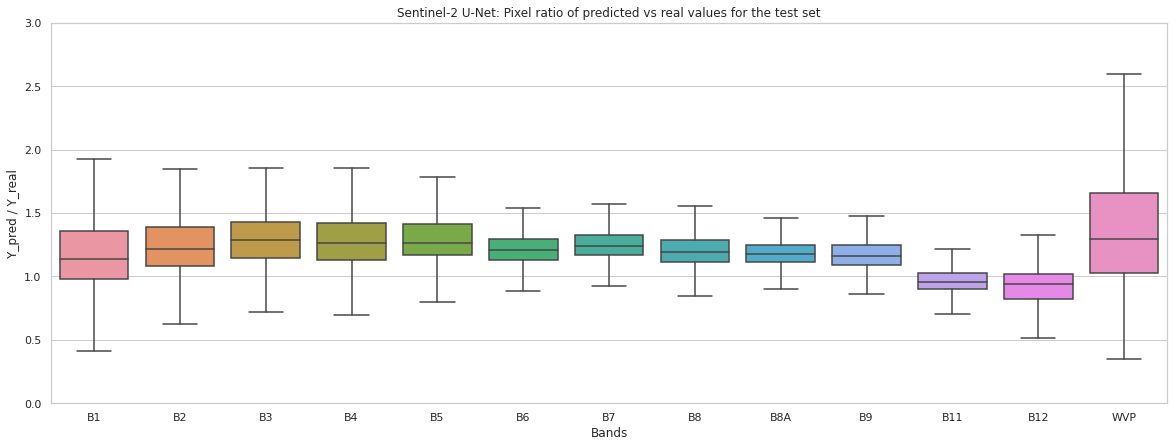

In [32]:
import seaborn as sns
test = dataset.TiffDataset(df_test, 256, True)
boxplot = {}
boxplot["band"] = []
boxplot["val"] = []
out = np.zeros(preds.shape[1])
samples = 1000

BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
for sample in range(len(test)):
    test = dataset.TiffDataset(df_test, 504, True)
    #id = np.random.randint(0, len(test))
    item = test[sample]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    for sample in range(samples):
        idx = np.random.randint(0, preds.shape[2])
        idy = np.random.randint(0, preds.shape[3])
        for band in range(preds.shape[1]):
            if band == 12:
                pass
            else:
                if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                    boxplot["band"].append(BANDS_L2A[band])
                    boxplot["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
                else:
                    out[band] += 1
            


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot["band"], y=boxplot["val"], order=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'WVP'], showfliers = False)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set(ylim=(0,3))
ax.set_title('Sentinel-2 U-Net: Pixel ratio of predicted vs real values for the test set')

In [33]:
fig.savefig("s2_unet_13_bands_ratio_boxplot_test_set.pdf", bbox_inches='tight')

In [34]:
out/(len(test)*samples) #Ratio of samples with real values < 0.05 for each band

array([0.64703, 0.56219, 0.33124, 0.37336, 0.06789, 0.04222, 0.04156,
       0.0427 , 0.04164, 0.0388 , 0.09772, 0.16247, 0.     , 0.205  ])

89


Text(0.5, 1.0, 'Pixel ratio of predicted vs real values for test image: 89')

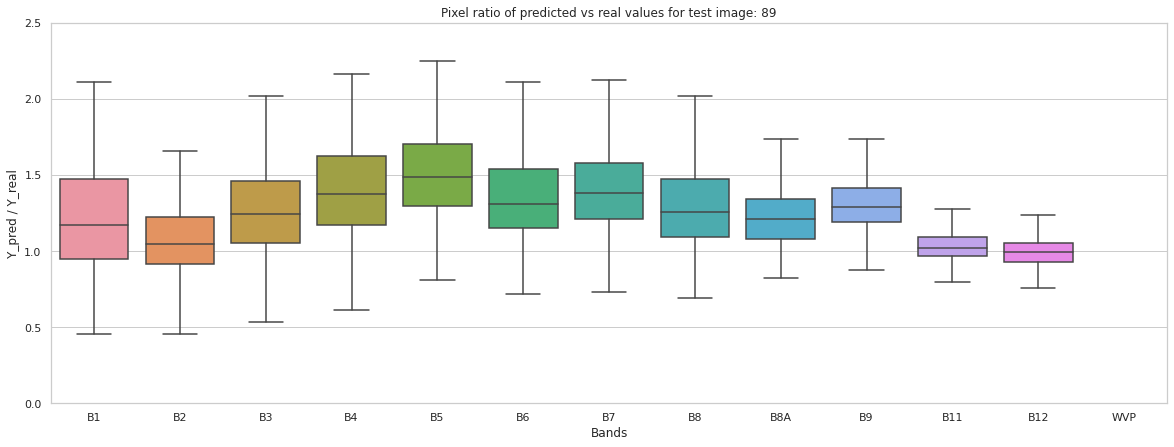

In [107]:
import seaborn as sns
boxplot_2 = {}
boxplot_2["band"] = []
boxplot_2["val"] = []
out_2 = np.zeros(preds.shape[1])
samples = 1000
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']
test = dataset.TiffDataset(df_test, 504, True)
idn = 89 #np.random.randint(0, len(test))
print(idn)
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

for sample in range(samples):
    idx = np.random.randint(0, preds.shape[2])
    idy = np.random.randint(0, preds.shape[3])
    for band in range(preds.shape[1]):
        if band == 12:
            pass
        else:
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot_2["band"].append(BANDS_L2A[band])
                boxplot_2["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out_2[band] += 1
            


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot_2["band"], y=boxplot_2["val"], order=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'WVP'], showfliers = False)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set(ylim=(0,2.5))
ax.set_title('Pixel ratio of predicted vs real values for test image: {}'.format(idn))

In [108]:
fig.savefig("13_s2_fcnn_pixel_ratio_img_{}.pdf".format(idn), bbox_inches='tight')

In [109]:
out_2/samples #Ratio of samples with real values < 0.05 for each band

array([0.93 , 0.794, 0.593, 0.36 , 0.026, 0.004, 0.003, 0.004, 0.002,
       0.   , 0.   , 0.   , 0.   , 0.999])

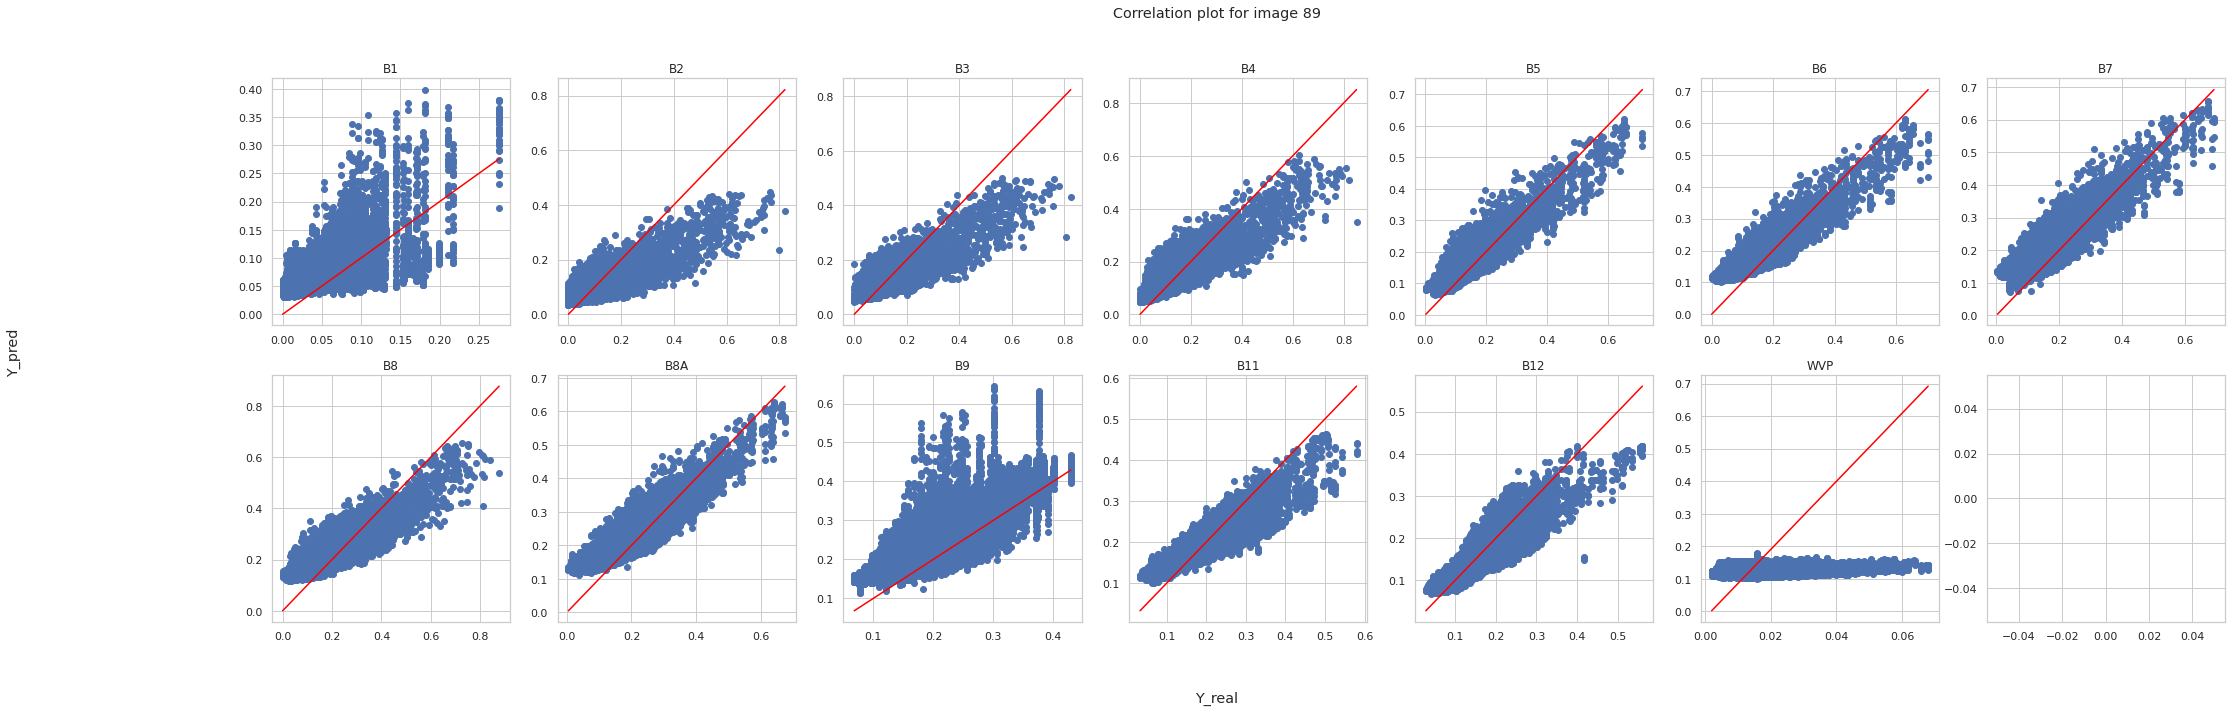

In [110]:
sns.set_theme(style="whitegrid")
test = dataset.TiffDataset(df_test, 504, True)
#idn = 27 #np.random.randint(0, len(test))
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
            
BANDS_L2A = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP']


fig, axs = plt.subplots(2,7,figsize=(35,10))
band=1

for band in range(6):
    axs[0, band].plot( [item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()],[item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()], c='red' )
    axs[1, band].plot( [item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().min(),item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().max()],[item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().min(),item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy().max()], c='red')
    axs[0, band].scatter(item['sl2a'][band].cpu().detach().numpy(), preds[0][band].cpu().detach().numpy())
    axs[0, band].set_title(BANDS_L2A[band])
    axs[1, band].scatter(item['sl2a'][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy(), preds[0][band+int(len(BANDS_L2A)/2)].cpu().detach().numpy())
    axs[1, band].set_title(BANDS_L2A[band+int(len(BANDS_L2A)/2)])

axs[0, 6].plot( [item['sl2a'][6].cpu().detach().numpy().min(),item['sl2a'][6].cpu().detach().numpy().max()],[item['sl2a'][6].cpu().detach().numpy().min(),item['sl2a'][6].cpu().detach().numpy().max()], c='red' )  
axs[0, 6].scatter(item['sl2a'][6].cpu().detach().numpy(), preds[0][6].cpu().detach().numpy())
axs[0, 6].set_title(BANDS_L2A[6])

axs[1,5].clear()
axs[1, 5].plot( [item['sl2a'][13].cpu().detach().numpy().min(),item['sl2a'][13].cpu().detach().numpy().max()],[item['sl2a'][13].cpu().detach().numpy().min(),item['sl2a'][6].cpu().detach().numpy().max()], c='red' )  
axs[1, 5].scatter(item['sl2a'][13].cpu().detach().numpy(), preds[0][13].cpu().detach().numpy())
axs[1, 5].set_title(BANDS_L2A[13])

axs[1, 6].plot()  

axs[1, 6].set_title("")

fig.supxlabel('Y_real')
fig.supylabel('Y_pred')
    

plt.suptitle('Correlation plot for image {0}'.format(idn))
plt.show()

In [111]:
fig.savefig("13_fcnn_corr_img_{}.png".format(idn), dpi=50)

Plot predictions

89


Text(0.5, 1.0, 'Pred')

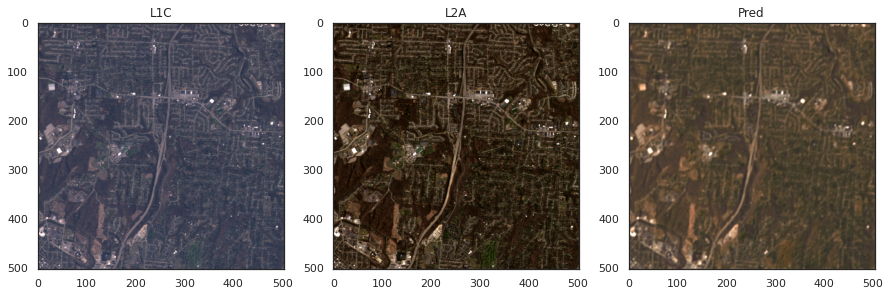

In [112]:
sns.set_theme(style="white")

test = dataset.TiffDataset(df_test, 504, True)
idx = idn# np.random.randint(0, len(test))
print(idx)
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

BANDS_RGB = ["B4", "B3", "B2"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = preds.detach().numpy()[0][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")

ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")
ax[2].imshow(predic)
ax[2].set_title("Pred")

In [113]:
fig.savefig("13_plot_prediction_{}.pdf".format(idx), bbox_inches='tight')

In [ ]:
#model_save = {'state_dict': model.state_dict(), 'lr': 0.001, 'alpha':0,'beta':0.2}

#torch.save(model_save, 'saved_models/unet_e15_batch50_no_aot_0_2_wvp_all_data.pth') 

Load previously saved model weights

In [26]:
model.load_state_dict(torch.load('saved_models/unet_e15_batch50_no_aot_0_2_wvp_all_data.pth')['state_dict'])

<All keys matched successfully>

In [ ]:
#torch.load('saved_models/fcnn_e20_batch50_model_save.pth')['params']